In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
#n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #區間為12小時
currency = ["SEK","CHF","CAD","GBP","JPY","EUR","AUD","SGD","HKD","NZD"]
#SEK:瑞典克朗  CHF:瑞士法郎 CAD:加拿大幣 GBP:英鎊 
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 9
tail = 21
epochs = 45
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
train_length=3 
test_length=1 

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, typeq):

    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    outcome[6]=(data2_sum[6])
    outcome[7]=(data2_sum[7])
    outcome[8]=(data2_sum[8])
    outcome[9]=(data2_sum[9])
    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    outcome[6]=data2_std[6]
    outcome[7]=data2_std[7]
    outcome[8]=data2_std[8]     
    outcome[9]=data2_std[9]     
    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:

"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=7))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:

"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:12]
    Test_q_reverse[:,2:12]=Test_q_reverse[:,12:22]
    Test_q_reverse[:,12:22]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()


(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6012 MiB, count=2, average=3006 MiB
[Training model......]
Train on 1668510 samples, validate on 514080 samples
Epoch 1/40
1668510/1668510 [==============================] - 12s 7us/step - loss: 0.6836 - acc: 0.5543 - val_loss: 0.6564 - val_acc: 0.5975
Epoch 2/40
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6492 - acc: 0.6054 - val_loss: 0.6362 - val_acc: 0.6010
Epoch 3/40
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6349 - acc: 0.6130 - val_loss: 0.6313 - val_acc: 0.6048
Epoch 4/40
1668510/1668510 [==============================] - 10s 6us/step - loss: 0.6293 - acc: 0.6159 - val_loss: 0.6286 - val_acc: 0.6062
Epoch 5/40
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6259 - acc: 0.6173 - val_loss: 0.6264 - val_acc: 0.6057
Epoch 6/40
1668510/1668510 

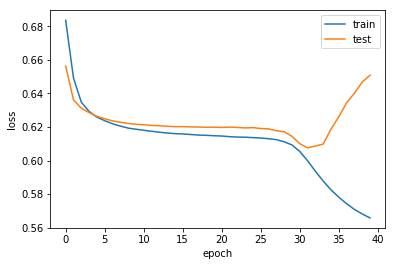

acc:
0.6551258308431038
val_acc:
0.6071000623510071


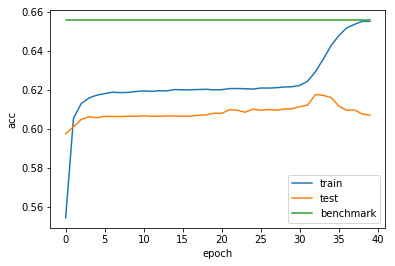

(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6090 MiB, count=74, average=82.3 MiB
[Training model......]
Train on 1626390 samples, validate on 584370 samples
Epoch 1/40
1626390/1626390 [==============================] - 11s 7us/step - loss: 0.6903 - acc: 0.5361 - val_loss: 0.6651 - val_acc: 0.5896
Epoch 2/40
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6532 - acc: 0.5989 - val_loss: 0.6382 - val_acc: 0.6082
Epoch 3/40
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6367 - acc: 0.6120 - val_loss: 0.6318 - val_acc: 0.6101
Epoch 4/40
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6302 - acc: 0.6147 - val_loss: 0.6288 - val_acc: 0.6099
Epoch 5/40
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6265 - acc: 0.6161 - val_loss: 0.6269 - val_acc: 0.6087
Epoch 6/40
1626390/1626

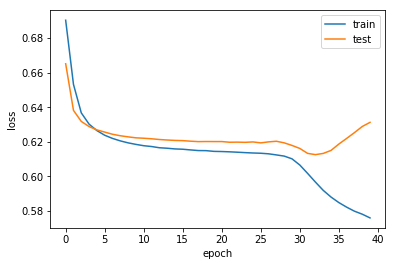

acc:
0.6500107600291534
val_acc:
0.6020637609260288


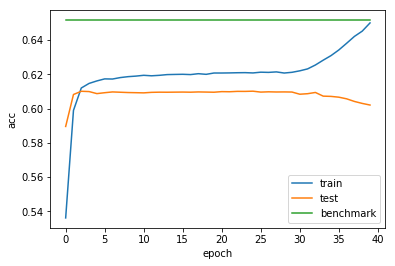

(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6237 MiB, count=75, average=83.2 MiB
[Training model......]
Train on 1700460 samples, validate on 563760 samples
Epoch 1/40
1700460/1700460 [==============================] - 12s 7us/step - loss: 0.6783 - acc: 0.5587 - val_loss: 0.6521 - val_acc: 0.6017
Epoch 2/40
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.6459 - acc: 0.6071 - val_loss: 0.6334 - val_acc: 0.6105
Epoch 3/40
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.6334 - acc: 0.6123 - val_loss: 0.6269 - val_acc: 0.6105
Epoch 4/40
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.6286 - acc: 0.6140 - val_loss: 0.6241 - val_acc: 0.6099
Epoch 5/40
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.6256 - acc: 0.6143 - val_loss: 0.6225 - val_acc: 0.6115
Epoch 6/40
1700460/1700

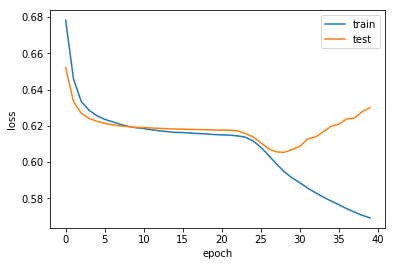

acc:
0.6529003916584473
val_acc:
0.611946572896452


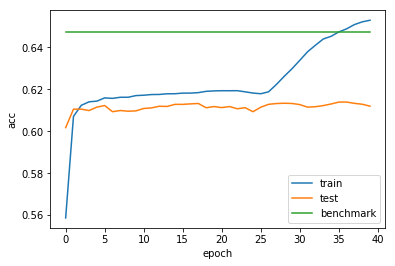

(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6096 MiB, count=76, average=80.2 MiB
[Training model......]
Train on 1675170 samples, validate on 537840 samples
Epoch 1/40
1675170/1675170 [==============================] - 13s 8us/step - loss: 0.6950 - acc: 0.5231 - val_loss: 0.6684 - val_acc: 0.5841
Epoch 2/40
1675170/1675170 [==============================] - 10s 6us/step - loss: 0.6537 - acc: 0.5954 - val_loss: 0.6343 - val_acc: 0.6099
Epoch 3/40
1675170/1675170 [==============================] - 10s 6us/step - loss: 0.6349 - acc: 0.6106 - val_loss: 0.6279 - val_acc: 0.6108
Epoch 4/40
1675170/1675170 [==============================] - 10s 6us/step - loss: 0.6286 - acc: 0.6138 - val_loss: 0.6254 - val_acc: 0.6112
Epoch 5/40
1675170/1675170 [==============================] - 9s 6us/step - loss: 0.6253 - acc: 0.6154 - val_loss: 0.6238 - val_acc: 0.6151
Epoch 6/40
1675170/16751

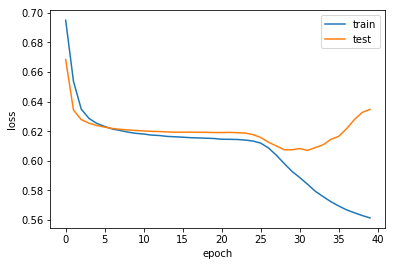

acc:
0.6553907962156436
val_acc:
0.6058567603854716


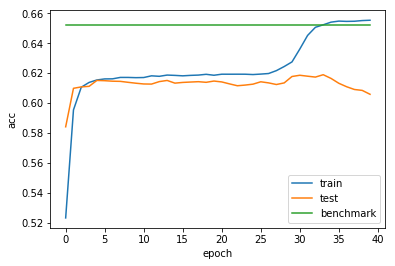

(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6304 MiB, count=77, average=81.9 MiB
[Training model......]
Train on 1698930 samples, validate on 589680 samples
Epoch 1/40
1698930/1698930 [==============================] - 14s 8us/step - loss: 0.6849 - acc: 0.5522 - val_loss: 0.6532 - val_acc: 0.5941
Epoch 2/40
1698930/1698930 [==============================] - 10s 6us/step - loss: 0.6504 - acc: 0.6010 - val_loss: 0.6340 - val_acc: 0.6005
Epoch 3/40
1698930/1698930 [==============================] - 10s 6us/step - loss: 0.6356 - acc: 0.6094 - val_loss: 0.6276 - val_acc: 0.6028
Epoch 4/40
1698930/1698930 [==============================] - 10s 6us/step - loss: 0.6295 - acc: 0.6121 - val_loss: 0.6246 - val_acc: 0.6063
Epoch 5/40
1698930/1698930 [==============================] - 10s 6us/step - loss: 0.6259 - acc: 0.6136 - val_loss: 0.6225 - val_acc: 0.6056
Epoch 6/40
1698930/1698

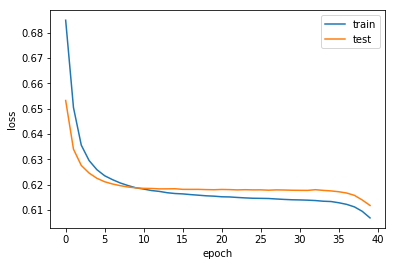

acc:
0.6211656748855217
val_acc:
0.6073378781340142


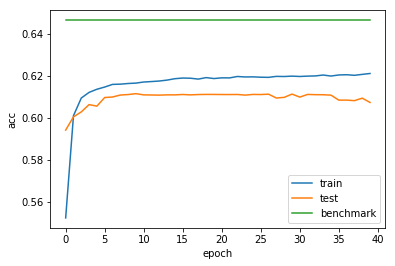

In [9]:
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]    
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((22,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 36, 10)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       1020        input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [8]:

"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:12]
    Test_q_reverse[:,2:12]=Test_q_reverse[:,12:22]
    Test_q_reverse[:,12:22]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)

    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    



In [9]:
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]    
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((22,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6074 MiB, count=2, average=3037 MiB
[Training model......]
Train on 1648620 samples, validate on 556200 samples
Epoch 1/45
1648620/1648620 [==============================] - 13s 8us/step - loss: 0.6842 - acc: 0.5492 - val_loss: 0.6508 - val_acc: 0.6184
Epoch 2/45
1648620/1648620 [==============================] - 9s 6us/step - loss: 0.6490 - acc: 0.6011 - val_loss: 0.6286 - val_acc: 0.6219
Epoch 3/45
1648620/1648620 [==============================] - 9s 6us/step - loss: 0.6352 - acc: 0.6105 - val_loss: 0.6238 - val_acc: 0.6158
Epoch 4/45
1648620/1648620 [==============================] - 10s 6us/step - loss: 0.6298 - acc: 0.6131 - val_loss: 0.6223 - val_acc: 0.6130
Epoch 5/45
1648620/1648620 [==============================] - 9s 6us/step - loss: 0.6269 - acc: 0.6143 - val_loss: 0.6207 - val_acc: 0.6119
Epoch 6/45
1648620/1648620 [

Epoch 7/45
1681380/1681380 [==============================] - 9s 6us/step - loss: 0.6213 - acc: 0.6163 - val_loss: 0.6172 - val_acc: 0.6100
Epoch 8/45
1681380/1681380 [==============================] - 11s 6us/step - loss: 0.6202 - acc: 0.6160 - val_loss: 0.6169 - val_acc: 0.6097
Epoch 9/45
1681380/1681380 [==============================] - 10s 6us/step - loss: 0.6196 - acc: 0.6167 - val_loss: 0.6168 - val_acc: 0.6095
Epoch 10/45
1681380/1681380 [==============================] - 9s 6us/step - loss: 0.6190 - acc: 0.6166 - val_loss: 0.6166 - val_acc: 0.6104
Epoch 11/45
1681380/1681380 [==============================] - 10s 6us/step - loss: 0.6184 - acc: 0.6173 - val_loss: 0.6166 - val_acc: 0.6102
Epoch 12/45
1681380/1681380 [==============================] - 9s 6us/step - loss: 0.6179 - acc: 0.6174 - val_loss: 0.6164 - val_acc: 0.6102
Epoch 13/45
1681380/1681380 [==============================] - 9s 6us/step - loss: 0.6176 - acc: 0.6172 - val_loss: 0.6164 - val_acc: 0.6102
Epoch 14/45
1

Epoch 15/45
1642860/1642860 [==============================] - 10s 6us/step - loss: 0.6175 - acc: 0.6183 - val_loss: 0.6176 - val_acc: 0.6107
Epoch 16/45
1642860/1642860 [==============================] - 9s 6us/step - loss: 0.6171 - acc: 0.6177 - val_loss: 0.6174 - val_acc: 0.6105
Epoch 17/45
1642860/1642860 [==============================] - 9s 6us/step - loss: 0.6169 - acc: 0.6188 - val_loss: 0.6172 - val_acc: 0.6107
Epoch 18/45
1642860/1642860 [==============================] - 10s 6us/step - loss: 0.6165 - acc: 0.6185 - val_loss: 0.6174 - val_acc: 0.6107
Epoch 19/45
1642860/1642860 [==============================] - 10s 6us/step - loss: 0.6163 - acc: 0.6187 - val_loss: 0.6176 - val_acc: 0.6103
Epoch 20/45
1642860/1642860 [==============================] - 9s 6us/step - loss: 0.6160 - acc: 0.6192 - val_loss: 0.6173 - val_acc: 0.6106
Epoch 21/45
1642860/1642860 [==============================] - 10s 6us/step - loss: 0.6159 - acc: 0.6194 - val_loss: 0.6172 - val_acc: 0.6107
Epoch 22/

Epoch 23/45
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6167 - acc: 0.6184 - val_loss: 0.6183 - val_acc: 0.6099
Epoch 24/45
1668510/1668510 [==============================] - 10s 6us/step - loss: 0.6167 - acc: 0.6182 - val_loss: 0.6182 - val_acc: 0.6103
Epoch 25/45
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6164 - acc: 0.6183 - val_loss: 0.6182 - val_acc: 0.6099
Epoch 26/45
1668510/1668510 [==============================] - 10s 6us/step - loss: 0.6162 - acc: 0.6183 - val_loss: 0.6184 - val_acc: 0.6097
Epoch 27/45
1668510/1668510 [==============================] - 10s 6us/step - loss: 0.6162 - acc: 0.6184 - val_loss: 0.6184 - val_acc: 0.6099
Epoch 28/45
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6160 - acc: 0.6190 - val_loss: 0.6183 - val_acc: 0.6099
Epoch 29/45
1668510/1668510 [==============================] - 9s 6us/step - loss: 0.6160 - acc: 0.6188 - val_loss: 0.6182 - val_acc: 0.6097
Epoch 30/4

Epoch 31/45
1626390/1626390 [==============================] - 9s 6us/step - loss: 0.6147 - acc: 0.6196 - val_loss: 0.6171 - val_acc: 0.6092
Epoch 32/45
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6146 - acc: 0.6194 - val_loss: 0.6171 - val_acc: 0.6090
Epoch 33/45
1626390/1626390 [==============================] - 9s 6us/step - loss: 0.6144 - acc: 0.6193 - val_loss: 0.6172 - val_acc: 0.6091
Epoch 34/45
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6145 - acc: 0.6194 - val_loss: 0.6172 - val_acc: 0.6090
Epoch 35/45
1626390/1626390 [==============================] - 9s 6us/step - loss: 0.6143 - acc: 0.6197 - val_loss: 0.6171 - val_acc: 0.6088
Epoch 36/45
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6141 - acc: 0.6200 - val_loss: 0.6171 - val_acc: 0.6089
Epoch 37/45
1626390/1626390 [==============================] - 10s 6us/step - loss: 0.6141 - acc: 0.6201 - val_loss: 0.6171 - val_acc: 0.6087
Epoch 38/

1700460/1700460 [==============================] - 11s 6us/step - loss: 0.5740 - acc: 0.6456 - val_loss: 0.6295 - val_acc: 0.6110
Epoch 39/45
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.5714 - acc: 0.6484 - val_loss: 0.6330 - val_acc: 0.6119
Epoch 40/45
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.5690 - acc: 0.6507 - val_loss: 0.6379 - val_acc: 0.6098
Epoch 41/45
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.5669 - acc: 0.6516 - val_loss: 0.6392 - val_acc: 0.6087
Epoch 42/45
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.5647 - acc: 0.6518 - val_loss: 0.6423 - val_acc: 0.6069
Epoch 43/45
1700460/1700460 [==============================] - 11s 6us/step - loss: 0.5631 - acc: 0.6522 - val_loss: 0.6465 - val_acc: 0.6043
Epoch 44/45
1700460/1700460 [==============================] - 10s 6us/step - loss: 0.5616 - acc: 0.6521 - val_loss: 0.6457 - val_acc: 0.6043
Epoch 45/45
170046

[[0.48341224]
 [0.47775084]
 [0.49034062]
 ...
 [0.9999683 ]
 [0.08574121]
 [0.00214855]]
329569 0.6127640190391195
trend_test_acc:
164427 0.6114346273984829
vol_test_acc:
165142 0.6140934106797561
reverse section--------------------------------------------------------------------------
[[0.4118947 ]
 [0.4925523 ]
 [0.4835908 ]
 ...
 [0.8168301 ]
 [0.27689284]
 [0.27689284]]
猜答案多的那邊 benchacc1:
0.5173955079577569
參考前一個答案 benchacc2:
0.6325449947939907
(148335, 1)
finish dataread
(None, 3, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=6304 MiB, count=78, average=80.8 MiB
[Training model......]
Train on 1698930 samples, validate on 589680 samples
Epoch 1/45
1698930/1698930 [==============================] - 14s 8us/step - loss: 0.6906 - acc: 0.5329 - val_loss: 0.6678 - val_acc: 0.5663
Epoch 2/45
1698930/1698930 [==============================] - 10s 6us/step - loss: 0.6560 - acc: 0.5916 - val_loss: 0.6358 - val_acc:

1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6341 - acc: 0.6108 - val_loss: 0.6249 - val_acc: 0.6124
Epoch 4/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6291 - acc: 0.6133 - val_loss: 0.6232 - val_acc: 0.6132
Epoch 5/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6262 - acc: 0.6146 - val_loss: 0.6222 - val_acc: 0.6095
Epoch 6/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6242 - acc: 0.6162 - val_loss: 0.6215 - val_acc: 0.6095
Epoch 7/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6228 - acc: 0.6163 - val_loss: 0.6208 - val_acc: 0.6095
Epoch 8/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6215 - acc: 0.6165 - val_loss: 0.6205 - val_acc: 0.6096
Epoch 9/45
1704240/1704240 [==============================] - 10s 6us/step - loss: 0.6207 - acc: 0.6168 - val_loss: 0.6202 - val_acc: 0.6085
Epoch 10/45
1704240/1704

Epoch 11/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6199 - acc: 0.6169 - val_loss: 0.6184 - val_acc: 0.6132
Epoch 12/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6193 - acc: 0.6170 - val_loss: 0.6181 - val_acc: 0.6132
Epoch 13/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6189 - acc: 0.6172 - val_loss: 0.6179 - val_acc: 0.6132
Epoch 14/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6183 - acc: 0.6174 - val_loss: 0.6177 - val_acc: 0.6131
Epoch 15/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6180 - acc: 0.6175 - val_loss: 0.6176 - val_acc: 0.6130
Epoch 16/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6176 - acc: 0.6176 - val_loss: 0.6174 - val_acc: 0.6132
Epoch 17/45
1683630/1683630 [==============================] - 10s 6us/step - loss: 0.6172 - acc: 0.6176 - val_loss: 0.6173 - val_acc: 0.6129
Epoch 

1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6166 - acc: 0.6174 - val_loss: 0.6193 - val_acc: 0.6094
Epoch 19/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6163 - acc: 0.6180 - val_loss: 0.6192 - val_acc: 0.6092
Epoch 20/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6162 - acc: 0.6180 - val_loss: 0.6191 - val_acc: 0.6107
Epoch 21/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6161 - acc: 0.6179 - val_loss: 0.6190 - val_acc: 0.6078
Epoch 22/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6159 - acc: 0.6184 - val_loss: 0.6190 - val_acc: 0.6078
Epoch 23/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6156 - acc: 0.6184 - val_loss: 0.6188 - val_acc: 0.6080
Epoch 24/45
1704150/1704150 [==============================] - 10s 6us/step - loss: 0.6155 - acc: 0.6187 - val_loss: 0.6189 - val_acc: 0.6085
Epoch 25/45
170415

Epoch 26/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6154 - acc: 0.6197 - val_loss: 0.6184 - val_acc: 0.6047
Epoch 27/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6152 - acc: 0.6195 - val_loss: 0.6184 - val_acc: 0.6055
Epoch 28/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6152 - acc: 0.6197 - val_loss: 0.6184 - val_acc: 0.6038
Epoch 29/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6151 - acc: 0.6201 - val_loss: 0.6185 - val_acc: 0.6030
Epoch 30/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6150 - acc: 0.6202 - val_loss: 0.6181 - val_acc: 0.6055
Epoch 31/45
1676610/1676610 [==============================] - 10s 6us/step - loss: 0.6149 - acc: 0.6202 - val_loss: 0.6183 - val_acc: 0.6027
Epoch 32/45
1676610/1676610 [==============================] - 9s 6us/step - loss: 0.6150 - acc: 0.6201 - val_loss: 0.6182 - val_acc: 0.6031
Epoch 3